# GRG Detection Model Testing

This notebook allows you to test trained Mask R-CNN models on the test dataset.

## 1. Setup and Imports

In [1]:
import os
import sys
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Add detectron2 and project paths
detectron2_root = Path("/home/s4861264/detectron2")
project_root = detectron2_root / "projects/LoTSS-GRG-detect"
sys.path.insert(0, str(detectron2_root))
sys.path.insert(0, str(project_root))

import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# Import custom modules
from data.register_dataset import main as register_datasets
from data.dataset_mapper import GRGDatasetMapper
from evaluation.grg_evaluator import GRGEvaluator
from detectron2.evaluation import COCOEvaluator

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA L4


## 2. Configuration

Set the path to your trained model and config file.

In [2]:
# Paths
CONFIG_FILE = str(project_root / "configs/mask_rcnn_R_50_FPN_grg.yaml")
MODEL_WEIGHTS = str(project_root / "scripts/output/grg_mask_rcnn/model_0022499.pth")
DATASET_CONFIG = str(project_root / "config/dataset.yaml")
OUTPUT_DIR = str(project_root / "scripts/output/grg_mask_rcnn/test_results")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Config file: {CONFIG_FILE}")
print(f"Model weights: {MODEL_WEIGHTS}")
print(f"Dataset config: {DATASET_CONFIG}")
print(f"Output directory: {OUTPUT_DIR}")

# Check if model exists
if os.path.exists(MODEL_WEIGHTS):
    print(f"✓ Model found: {MODEL_WEIGHTS}")
else:
    print(f"✗ Model not found: {MODEL_WEIGHTS}")
    print("Available model checkpoints:")
    checkpoint_dir = os.path.dirname(MODEL_WEIGHTS)
    if os.path.exists(checkpoint_dir):
        for f in sorted(os.listdir(checkpoint_dir)):
            if f.endswith('.pth'):
                print(f"  - {f}")

Config file: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/configs/mask_rcnn_R_50_FPN_grg.yaml
Model weights: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/model_0022499.pth
Dataset config: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/config/dataset.yaml
Output directory: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/test_results
✓ Model found: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/model_0022499.pth


## 3. Register Datasets

In [3]:
# Register datasets
registered = register_datasets(DATASET_CONFIG)
print(f"Registered datasets: {registered}")

# Get test dataset name
test_dataset_name = [d for d in registered if 'test' in d][0]
print(f"\nTest dataset: {test_dataset_name}")

# Check dataset
test_data = DatasetCatalog.get(test_dataset_name)
print(f"Number of test images: {len(test_data)}")
print(f"\nFirst image info:")
print(f"  File: {test_data[0]['file_name']}")
print(f"  Image ID: {test_data[0]['image_id']}")
print(f"  Height: {test_data[0]['height']}, Width: {test_data[0]['width']}")
print(f"  Annotations: {len(test_data[0].get('annotations', []))}")

Registered datasets: ['grg_train', 'grg_val', 'grg_test']

Test dataset: grg_test
Number of test images: 1223

First image info:
  File: /home/s4861264/project_data/split/test/images/LoTSS_GRG_0000000009_RA27.91638428747_DEC17.94133434196.png
  Image ID: 9
  Height: 300, Width: 300
  Annotations: 1


## 4. Load Model Configuration and Weights

In [4]:
# Setup config
cfg = get_cfg()
cfg.merge_from_file(CONFIG_FILE)

# Set model weights
cfg.MODEL.WEIGHTS = MODEL_WEIGHTS

# Set score threshold for visualization (adjust as needed)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

# Set device
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Set test dataset
cfg.DATASETS.TEST = (test_dataset_name,)

print(f"Model device: {cfg.MODEL.DEVICE}")
print(f"Score threshold: {cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST}")
print(f"Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")

# Create predictor
predictor = DefaultPredictor(cfg)
print("\n✓ Model loaded successfully!")

Model device: cuda
Score threshold: 0.8
Number of classes: 1



✓ Model loaded successfully!


## 5. Test on Sample Images

Let's visualize predictions on a few test images.

Image 3544: 1 detections
  Scores: [0.99900925]
Image 3510: 1 detections
  Scores: [0.99487275]
Image 7862: 1 detections
  Scores: [0.99590874]
Image 4466: 1 detections
  Scores: [0.99467385]
Image 256: 1 detections
  Scores: [0.9994832]


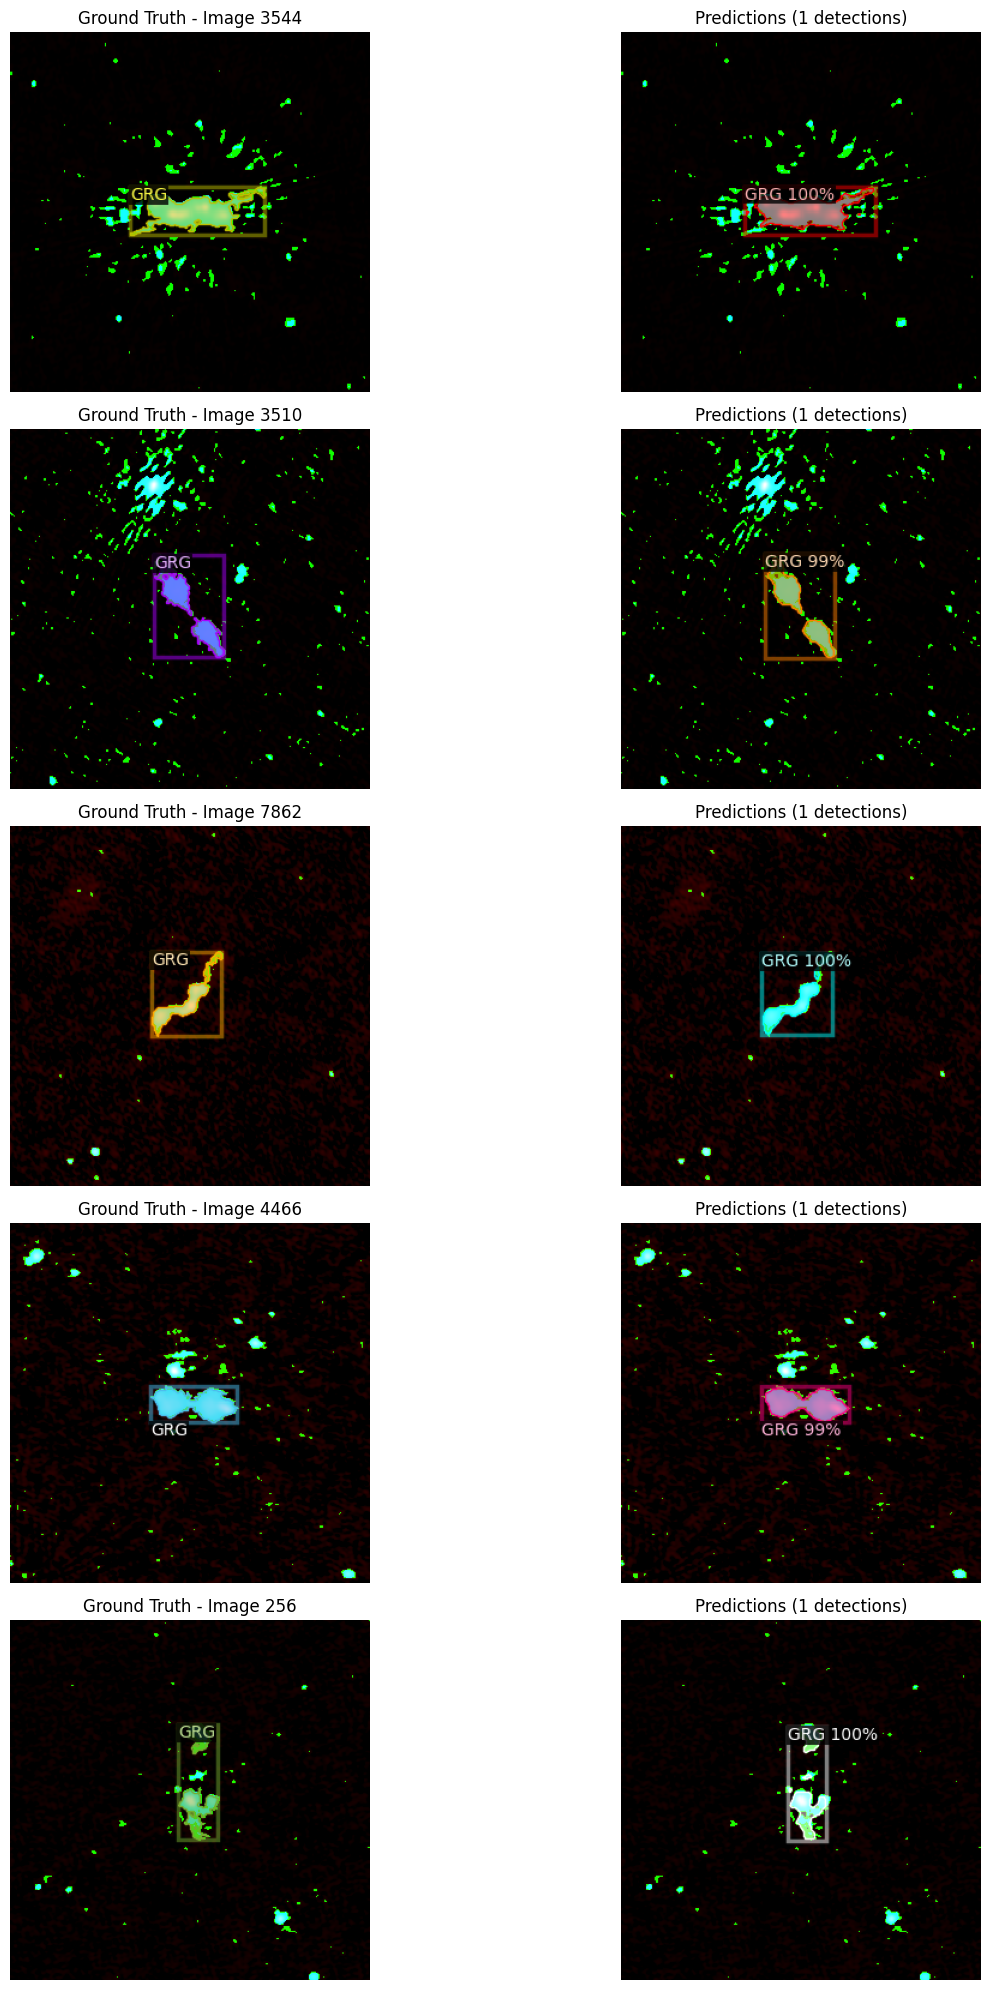

In [5]:
# Select random test images
np.random.seed(48)
num_samples = 5
sample_indices = np.random.choice(len(test_data), min(num_samples, len(test_data)), replace=False)

# Get metadata
metadata = MetadataCatalog.get(test_dataset_name)

# Create mapper with proposals
mapper = GRGDatasetMapper(cfg, is_train=False)

fig, axes = plt.subplots(num_samples, 2, figsize=(15, num_samples * 4))
if num_samples == 1:
    axes = axes.reshape(1, -1)

# Put model in eval mode
predictor.model.eval()

for idx, sample_idx in enumerate(sample_indices):
    d = test_data[sample_idx]
    
    # Read image
    img = cv2.imread(d["file_name"])
    
    # Use mapper to process the data (this loads proposals)
    with torch.no_grad():
        inputs = mapper(d.copy())
        # Prepare for model - add to batch
        inputs_list = [inputs]
        # Run model
        outputs = predictor.model(inputs_list)[0]
    
    # Visualize ground truth
    v_gt = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    if "annotations" in d:
        v_gt = v_gt.draw_dataset_dict(d)
    gt_img = v_gt.get_image()
    
    # Visualize predictions
    v_pred = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    instances = outputs["instances"].to("cpu")
    v_pred = v_pred.draw_instance_predictions(instances)
    pred_img = v_pred.get_image()
    
    # Plot
    axes[idx, 0].imshow(gt_img)
    axes[idx, 0].set_title(f"Ground Truth - Image {d['image_id']}")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(pred_img)
    axes[idx, 1].set_title(f"Predictions ({len(instances)} detections)")
    axes[idx, 1].axis('off')
    
    print(f"Image {d['image_id']}: {len(instances)} detections")
    if len(instances) > 0:
        print(f"  Scores: {instances.scores.numpy()}")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sample_predictions.png"), dpi=150, bbox_inches='tight')
plt.show()

## 6. Full Evaluation on Test Set

Run complete evaluation with both COCO metrics and custom GRG metrics.

In [12]:
from detectron2.evaluation import DatasetEvaluators

# Get annotations path
annotations_path = MetadataCatalog.get(test_dataset_name).json_file

# Create evaluators
evaluators = DatasetEvaluators(
    [COCOEvaluator(test_dataset_name, output_dir=OUTPUT_DIR),
     GRGEvaluator(
        coco_images=test_data,
        annotations_path=annotations_path,
        score_threshold=cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    )]
)
# Build test loader
test_loader = build_detection_test_loader(
    cfg,
    test_dataset_name,
    mapper=GRGDatasetMapper(cfg, is_train=False)
)

print(f"Running evaluation on {len(test_data)} test images...")
print(f"This may take a few minutes...\n")

# Run evaluation
results = inference_on_dataset(predictor.model, test_loader, evaluators)

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Running evaluation on 1223 test images...
This may take a few minutes...

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.836
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.883
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]

## 7. Display Results

In [13]:
# Display all results
for task, metrics in results.items():
    print(f"\n{task.upper()}:")
    if isinstance(metrics, dict):
        for metric_name, value in metrics.items():
            if isinstance(value, float):
                print(f"  {metric_name}: {value:.4f}")
            else:
                print(f"  {metric_name}: {value}")
    else:
        print(f"  {metrics}")

# Save results to JSON
results_file = os.path.join(OUTPUT_DIR, "test_results.json")
with open(results_file, 'w') as f:
    # Convert any non-serializable values
    serializable_results = {}
    for k, v in results.items():
        if isinstance(v, dict):
            serializable_results[k] = {kk: float(vv) if isinstance(vv, (int, float, np.number)) else str(vv) 
                                       for kk, vv in v.items()}
        else:
            serializable_results[k] = v
    json.dump(serializable_results, f, indent=2)

print(f"\n✓ Results saved to: {results_file}")


BBOX:
  AP: 83.6066
  AP50: 92.5480
  AP75: 88.0294
  APs: 84.6535
  APm: 91.8812
  APl: 38.8318

SEGM:
  AP: 55.9067
  AP50: 89.2749
  AP75: 59.5050
  APs: 47.4134
  APm: 63.1682
  APl: 59.7030

GRG:
  segm_accuracy: 0.5602
  segm_precision: 0.6966
  segm_recall: 0.7409
  bbox_accuracy: 0.7847
  bbox_precision: 0.8496
  bbox_recall: 0.9114

✓ Results saved to: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/test_results/test_results.json


## 8. Analyze Predictions by Score Threshold - Not being used currently since I already take the best predictions based on the model's confidence scores.

See how performance changes at different confidence thresholds.

In [14]:
# # Test different thresholds
# thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
# threshold_results = []

# print("Testing different score thresholds...")
# for thresh in thresholds:
#     # Create evaluator with this threshold
#     evaluator = GRGEvaluator(
#         coco_images=test_data,
#         annotations_path=annotations_path,
#         score_threshold=thresh
#     )
    
#     # Rebuild test loader
#     test_loader = build_detection_test_loader(
#         cfg,
#         test_dataset_name,
#         mapper=GRGDatasetMapper(cfg, is_train=False)
#     )
    
#     # Run evaluation
#     result = inference_on_dataset(predictor.model, test_loader, evaluator)
    
#     if 'GRG' in result:
#         threshold_results.append({
#             'threshold': thresh,
#             **result['GRG']
#         })
#         print(f"Threshold {thresh:.1f}: Seg_Acc={result['GRG']['segm_accuracy']:.3f}, "
#               f"Seg_Prec={result['GRG']['segm_precision']:.3f}, Seg_Rec={result['GRG']['segm_recall']:.3f}, "
#               f"Bbox_Acc={result['GRG']['bbox_accuracy']:.3f}, Bbox_Prec={result['GRG']['bbox_precision']:.3f}, Bbox_Rec={result['GRG']['bbox_recall']:.3f}")

# # Plot results
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# metrics = ['segm_accuracy', 'segm_precision', 'segm_recall', 'bbox_accuracy', 'bbox_precision', 'bbox_recall']
# titles = ['Accuracy', 'Precision', 'Recall']

# for idx, (metric, title) in enumerate(zip(metrics, titles)):
#     values = [r[metric] for r in threshold_results]
#     axes[idx].plot(thresholds, values, 'o-', linewidth=2, markersize=8)
#     axes[idx].set_xlabel('Score Threshold')
#     axes[idx].set_ylabel(title)
#     axes[idx].set_title(f'{title} vs Threshold')
#     axes[idx].grid(True, alpha=0.3)
#     axes[idx].set_ylim([0, 1])

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, "threshold_analysis.png"), dpi=150, bbox_inches='tight')
# plt.show()

## 9. Summary

Key findings from the test set evaluation.

In [15]:
print("="*80)
print("TEST SET EVALUATION SUMMARY")
print("="*80)
print(f"\nModel: {MODEL_WEIGHTS}")
print(f"Test Dataset: {test_dataset_name} ({len(test_data)} images)")
print(f"Score Threshold: {cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST}")
print("\n" + "="*80)

# Display main results
if 'GRG' in results:
    print("\nGRG Detection Metrics:")
    print(f"  Segmentation Accuracy:  {results['GRG']['segm_accuracy']:.1%}")
    print(f"  Segmentation Precision: {results['GRG']['segm_precision']:.1%}")
    print(f"  Segmentation Recall:    {results['GRG']['segm_recall']:.1%}")
    print(f"  Bounding Box Accuracy:  {results['GRG']['bbox_accuracy']:.1%}")
    print(f"  Bounding Box Precision: {results['GRG']['bbox_precision']:.1%}")
    print(f"  Bounding Box Recall:    {results['GRG']['bbox_recall']:.1%}")

if 'segm' in results:
    print("\nCOCO Segmentation Metrics:")
    for key in ['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']:
        if key in results['segm']:
            print(f"  {key}: {results['segm'][key]:.1f}")

if 'bbox' in results:
    print("\nCOCO Detection Metrics:")
    for key in ['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']:
        if key in results['bbox']:
            print(f"  {key}: {results['bbox'][key]:.1f}")

print("\n" + "="*80)
print(f"\nAll results saved to: {OUTPUT_DIR}")
print("="*80)

TEST SET EVALUATION SUMMARY

Model: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/model_0022499.pth
Test Dataset: grg_test (1223 images)
Score Threshold: 0.8


GRG Detection Metrics:
  Segmentation Accuracy:  56.0%
  Segmentation Precision: 69.7%
  Segmentation Recall:    74.1%
  Bounding Box Accuracy:  78.5%
  Bounding Box Precision: 85.0%
  Bounding Box Recall:    91.1%

COCO Segmentation Metrics:
  AP: 55.9
  AP50: 89.3
  AP75: 59.5
  APs: 47.4
  APm: 63.2
  APl: 59.7

COCO Detection Metrics:
  AP: 83.6
  AP50: 92.5
  AP75: 88.0
  APs: 84.7
  APm: 91.9
  APl: 38.8


All results saved to: /home/s4861264/detectron2/projects/LoTSS-GRG-detect/scripts/output/grg_mask_rcnn/test_results


# Interpretation of Results

Segmentation: Recall > Precision which means that we catch most relevant GRG components but sometimes we include extra ones. Struggles with clean boundary likely because the dataset is not clean enough. Note: I also noticed that the model sometimes predicts components that I would also say are part of the GRG but were not annotated in the ground truth due to the imperfect nature of the dataset.

BBoxes: Very high recall which means that i rarely misses the correct GRG components. Precision is lower (still high though) which means that sometimes it exlcudes some relevant components. It assigns boxes in a more conservative way (maybe missing GRGs that take up a large area in the cutout).

Segmentation: Accuracy is low (~50%) due to the fact that there are many components in the ground truth that are a very small emmision island in the cutout, and the model struggles to segment those small components accurately.

BBoxes: Accuracy is higher (~80%) because the model is better at identifying the general area of the GRG components, even if it struggles with the precise segmentation. 
